# **`PHÂN TÍCH DỮ LIỆU THÔNG MINH`**
# **`ĐỒ ÁN THỰC HÀNH`** 

        THÀNH VIÊN NHÓM 

|       Họ và tên       |   MSSV   |
|:----------------------|---------:|
|   Nguyễn Thế Đạt      | 20120055 |
|    Trần Xuân Hòa      | 20120085 | 
| Lê Nguyễn Thanh Hoàng | 20120088 | 
|    Lê Hoàng Huy       | 20120105 | 
|  Nguyễn Việt Khoa     | 20120120 | 
|  Nguyễn Thành Nhân    | 20120151 | 

                BẢNG PHÂN CÔNG
    
|Công việc | MSSV |
|----|----|
|Khám phá + tiền xử lý + tạo đặc trưng | 20120055 |
|Mô hình Naive Bayes | 20120120 |
|Mô hình Random forest | 20120105 |
|Mô hình SVC | 20120151 |
|Mô hình Logistic Regression | 20120088 |
|Mô hình transformer+SVC | 20120085 |


## Giới thiệu chung về đồ án

- Đồ án này sẽ dựa trên cuộc thi <a href="https://www.kaggle.com/competitions/nlp-getting-started/overview">Natural Language Processing with Disaster Tweets</a> trên Kaggle. Trong đồ án này chúng ta cần xây dựng mô hình học máy dự đoán Tweet nào là nói về thảm họa thực sự và Tweet nào không.

- Dự liệu bao gồm train.csv và test.csv. Cả 2 tập đều có 4 cột dữ liệu bao gồm 'id', 'keyword', 'location', 'text'. Tuy nhiên ở tập dữ liệu train.csv sẽ có thêm cột `target` để sử dụng cho việc xây dựng mô hình.

    |   Dữ liệu     |   Dòng   |    Cột   |
    |:--------------|:--------:|---------:|
    |   train.csv   |   7613   |    5     |
    |   test.csv    |   3263   |    4     |

- Mỗi dòng của dữ liệu sẽ có những thì có những thông tin dạng văn bản để cho biết nó có phải là một thảm họa hay không.

## 0. Import

In [25]:
import re
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from unidecode import unidecode
import tensorflow as tf
from sentence_transformers import SentenceTransformer, util

## 1. Data procession

In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [3]:
print(train_df.columns)
print(test_df.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


### 1.1. Missing value

In [4]:
print(train_df.isnull().sum())
print('\n', train_df.shape)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

 (7613, 5)


Đối với Missing value nhóm quyết định xóa các dữ liệu bị thiếu của cột `keyword` còn đối với cột `location` thì giữ nguyên vì nó chiếm tới gần 1/3 dữ liệu.

In [5]:
train_df.dropna(subset=['keyword'], inplace=True)
train_df.isnull().sum()

id             0
keyword        0
location    2472
text           0
target         0
dtype: int64

### 1.2. Data Cleaning

Cột `keyword` có giá trị chứa '%20' thành ' '. Ví dụ 'airplane%20accident' thay '%20' bằng ' '.

Cột `text` xóa: 'url', 'html tag', 'emojis' và 'punctuations'.

In [6]:
def keyword_preprocess(text):
    if pd.notnull(text):
        text = text.replace("%20", " ")
    return text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [7]:
# Xử lý cột 'keyword'
train_df['keyword'] = train_df['keyword'].apply(keyword_preprocess)
test_df['keyword'] = test_df['keyword'].apply(keyword_preprocess)

In [8]:
#Xử lý cột 'text' ở train_df
train_df['text'] = train_df['text'].apply(remove_URL)
train_df['text'] = train_df['text'].apply(remove_html)
train_df['text'] = train_df['text'].apply(remove_emoji)
train_df['text'] = train_df['text'].apply(remove_punct)

#Xử lý cột 'text' ở test_df
test_df['text'] = test_df['text'].apply(remove_URL)
test_df['text'] = test_df['text'].apply(remove_html)
test_df['text'] = test_df['text'].apply(remove_emoji)
test_df['text'] = test_df['text'].apply(remove_punct)

In [9]:
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

## 2 Feature engineering

In [10]:
df1 = pd.read_csv('train_clean.csv')
df2 = pd.read_csv('test_clean.csv')

Sử dụng `TfidfVectorizer` để tính toán tần số xuất hiện của từ trong từng văn bản (Term Frequency - TF) và tần số xuất hiện của từ trong toàn bộ tập dữ liệu (Document Frequency - DF). Sau đó, tính giá trị Tfidf cho mỗi từ trong mỗi văn bản, kết hợp thông tin về TF và DF. Cho ra một ma trận biểu diễn các văn bản thành các vector số hóa, giúp cải thiện hiệu suất cho việc phân loại, gom cụm hay trích xuất thông tin.

In [27]:
vector=TfidfVectorizer(analyzer='word',max_features=5000,max_df=0.8)
X=vector.fit_transform(df1["text"])
y = df1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
df2 = pd.read_csv("test_clean.csv")
X1=vector.transform(df2["text"])

## 3 Train model

### 3.1 Naive Bayes

Mô hình `MultinomialNB` là một mô hình học máy có giám sát sử dụng cho bài toán phân loại văn bản. Nó dựa trên nguyên tắc của `Naive Bayes` và được sử dụng cho các tập dữ liệu có các đặc trưng rời rạc, chẳng hạn như đếm số lần xuất hiện của các từ trong văn bản. Mô hình xây dựng bộ "từ vựng" từ dữ liệu huấn luyện và tính xác suất xuất hiện của các từ trong "từ vựng" trong các lớp khác nhau. Sau đó, sử dụng các xác suất này để huấn luyện mô hình và phân loại các văn bản mới bằng cách dự đoán lớp có xác suất cao nhất cho mỗi văn bản. 

In [13]:
model1 = MultinomialNB()
model1.fit(X_train, y_train)

predictions = model1.predict(X1)
print(model1.score(X_test, y_test))

pd.DataFrame({"Id": df2["id"], "Target": predictions}).to_csv("data/submission.csv", index=False)

0.8067504963600265


### 3.2 Random Forest Classifier

Mô hình `RandomForestClassifier` là một mô hình học máy sử dụng trong bài toán phân loại. Nó dựa trên học kết hợp và sử dụng nhiều cây quyết định để thực hiện phân loại. Quá trình hoạt động bao gồm xây dựng nhiều cây quyết định độc lập, sau đó kết hợp kết quả dự đoán của chúng để đưa ra kết quả phân loại cuối cùng. `RandomForestClassifier` giúp tránh `overfitting` và tổng quát hóa tốt hơn do sử dụng nhiều cây và kết hợp kết quả của chúng. Các tham số quan trọng cần được điều chỉnh để cải thiện hiệu suất của mô hình. Mô hình này thường được sử dụng trong các bài toán phân loại phức tạp và đa dạng hoặc khi cần cải thiện tính tổng quát của mô hình.

In [36]:
estimators = range(100,1001,50)
best_score = 0
best_k = 0
score=[]
models = []

for i in estimators:
    model_ = RandomForestClassifier(n_estimators=i)
    model_.fit(X_train, y_train)

    accuracy_score_rfc = accuracy_score(y_test, model_.predict(X_test))
    score.append(accuracy_score_rfc)
    
    models.append(model_)

    if accuracy_score_rfc  > best_score:
        best_score = accuracy_score_rfc
        best_k = i

print(f"best C: {best_k}, best accurary: {best_score}")

best C: 650, best accurary: 0.8054268696227663


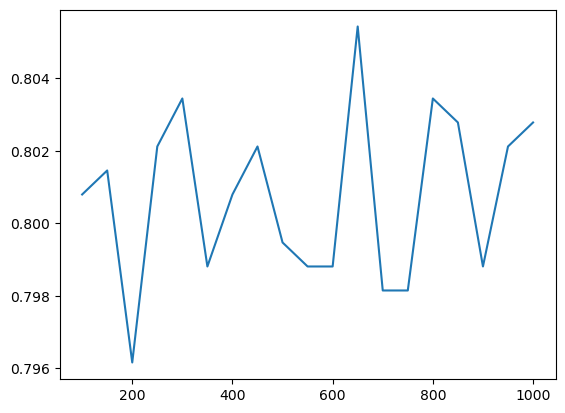

In [37]:
plt.plot([*estimators],score)

Sau nhiều lần thử thì nhóm thấy mô hình tốt nhất tại `n_estimators = 650`.

In [38]:
model2 = RandomForestClassifier(n_estimators=650, random_state=42)
model2.fit(X_train, y_train)

predictions = model2.predict(X1)
print(model2.score(X_test, y_test))

pd.DataFrame({"Id": df2["id"], "Target": predictions}).to_csv("data/submission1.csv", index=False)

0.8021178027796162


### 3.3 Support Vector Classifier

Mô hình `SVC` là một mô hình học máy được sử dụng trong bài toán phân loại. Nó dựa trên ý tưởng của máy vector hỗ trợ (Support Vector Machines - SVM) và tìm một đường ranh giới trong không gian đặc trưng để phân tách các lớp dữ liệu. `SVC` sử dụng các điểm dữ liệu gần nhất với đường ranh giới (hyperplane) để tối đa hóa khoảng cách giữa các lớp. Tham số `C` (mức độ chấp nhận lỗi) điều chỉnh mức độ "mềm" của đường ranh giới. Nó được sử dụng phổ biến trong các bài toán phân loại phức tạp, nhất là khi dữ liệu không phân tách tuyến tính. Tuy nhiên, việc huấn luyện `SVC` có thể tốn nhiều thời gian đối với các tập dữ liệu lớn.

In [41]:
C = [0.01,0.1, 0.5, 1, 1.5, 2, 5, 10]
#k = ['linear', 'poly', 'rbf', 'sigmoid']
best_score = 0
best_C = ''
score_1 = []
#best_k = ''
#score_2 = []
for i in C:
    model4 = SVC(C=i)
    model4.fit(X_train, y_train)

    accuracy_score_svc = accuracy_score(y_test, model4.predict(X_test))
    score_1.append(accuracy_score_svc)
    #score_2.append(accuracy_score_svc)

    if accuracy_score_svc  > best_score:
        best_score = accuracy_score_svc 
        best_C = i
        #best_k = i

    print(f"C: {i}, accurary: {accuracy_score_svc }")
    #print(f"k: {i}, accurary: {accuracy_score_svc }")

print(f"best C: {best_C}, best accurary: {best_score}")
#print(f"best k: {best_k}, best accurary: {best_score}")

C: 0.01, accurary: 0.5784248841826605
C: 0.1, accurary: 0.628722700198544
C: 0.5, accurary: 0.800794176042356
C: 1, accurary: 0.8067504963600265
C: 1.5, accurary: 0.8074123097286565
C: 2, accurary: 0.8047650562541363
C: 5, accurary: 0.8014559894109861
C: 10, accurary: 0.800132362673726
best C: 1.5, best accurary: 0.8074123097286565


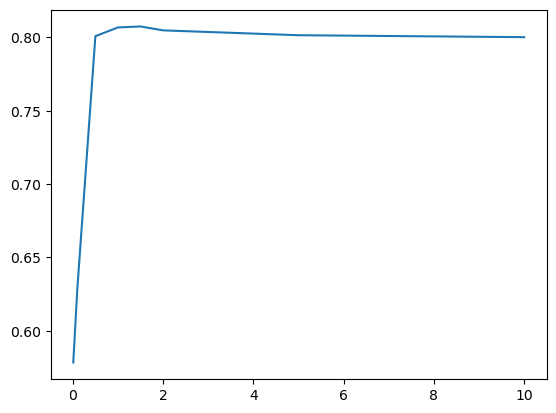

In [42]:
plt.plot(C,score_1);

Sau nhiều lần thử thì nhóm thấy mô hình tốt cao nhất tại `kernel = 'linear'` và `C = 1.5`.

In [17]:
model3 = SVC(C=1.5)
model3.fit(X_train, y_train)

predictions = model3.predict(X1)
print(model3.score(X_test, y_test))

pd.DataFrame({"Id": df2["id"], "Target": predictions}).to_csv("data/submission2.csv", index=False)

0.8067504963600265


### 3.4 Logistic Regression

Mô hình `LogisticRegression` là một mô hình học máy sử dụng cho bài toán phân loại hai lớp (binary classification). Nó tính toán xác suất của điểm dữ liệu thuộc vào lớp positive sử dụng hàm sigmoid. Trong quá trình huấn luyện, mô hình điều chỉnh các trọng số của đặc trưng để tối ưu hóa việc dự đoán xác suất cho các điểm dữ liệu huấn luyện bằng cách tối thiểu hóa hàm mất mát (loss function), như hàm `cross-entropy`. Sau đó, mô hình có thể dự đoán lớp của các điểm dữ liệu mới dựa trên xác suất và ngưỡng quyết định. Mô hình `LogisticRegression` là một lựa chọn phổ biến và hiệu quả cho các bài toán phân loại hai lớp.

In [18]:
model4 = LogisticRegression()
model4.fit(X_train, y_train)

predictions = model4.predict(X1)
print(model4.score(X_test, y_test))

pd.DataFrame({"Id": df2["id"], "Target": predictions}).to_csv("data/submission3.csv", index=False)

0.8027796161482462


### 3.5 SentenceTransformer

- `SentenceTransformer` là một thư viện Python mã nguồn mở sử dụng các mô hình mã hóa bổ sung để chuyển đổi các câu văn bản thành các vector số hóa chất lượng cao. Các vector số hóa này có thể được sử dụng cho nhiều tác vụ xử lý ngôn ngữ tự nhiên, chẳng hạn như so sánh sự tương đồng giữa các câu, phân loại văn bản, tóm tắt, dịch máy và nhiều tác vụ NLP khác. `SentenceTransformer` cung cấp các mô hình đã được đào tạo sẵn ở đây nhóm chọn mô hình `paraphrase-MiniLM-L6-v2`.

- Mô hình `paraphrase-MiniLM-L6-v2` là một mô hình mã hóa câu sử dụng kiến trúc Transformer. Nó được đào tạo trên một tập dữ liệu lớn chứa các cặp câu đồng nghĩa hoặc gần như đồng nghĩa. Mô hình này mã hóa các câu thành các vector số hóa chất lượng cao với số chiều nhỏ hơn so với các mô hình lớn hơn. Nó cung cấp chất lượng số hóa cao trong khi tiêu thụ tài nguyên tính toán thấp, `paraphrase-MiniLM-L6-v2` phù hợp cho các ứng dụng yêu cầu tài nguyên giới hạn nhưng vẫn cần hiệu suất cao.

In [19]:
enc_model = SentenceTransformer('paraphrase-MiniLM-L6-v2');

Sử dụng `unidecode` để loại bỏ các dấu câu tiếng Việt để đưa văn bản về dạng không dấu.

In [43]:
X_train_ = df1.text.apply(unidecode).to_numpy()
X_test1 = df2.text.apply(unidecode).to_numpy()
y_train_= df1.target.to_numpy()

X_train1, X_val, y_train1, y_val = train_test_split(X_train_, y_train_, test_size=0.1, random_state=42)

Sử dụng hàm `encode` của mô hình `paraphrase-MiniLM-L6-v2` để mã hóa các văn bản thành vector.

In [44]:
X_train1 = enc_model.encode(X_train1)
X_val = enc_model.encode(X_val)
X_test1 = enc_model.encode(X_test1)

In [45]:
C = [0.375, 1.25, 1.35, 1.5, 1.75, 2, 2.25, 2.5]
best_score = 0
best_C = ''
score_st = []
for i in C:
    model_ = SVC(C=i)
    model_.fit(X_train1, y_train1)

    accuracy_score_svc = accuracy_score(y_val, model_.predict(X_val))

    score_st.append(accuracy_score_svc)

    if accuracy_score_svc  > best_score:
        best_score = accuracy_score_svc 
        best_C = i

    print(f"C: {i}, accurary: {accuracy_score_svc }")

print(f"best C: {best_C}, best accurary: {best_score}")

C: 0.375, accurary: 0.8042328042328042
C: 1.25, accurary: 0.8068783068783069
C: 1.35, accurary: 0.8068783068783069
C: 1.5, accurary: 0.8121693121693122
C: 1.75, accurary: 0.8121693121693122
C: 2, accurary: 0.8095238095238095
C: 2.25, accurary: 0.8095238095238095
C: 2.5, accurary: 0.8042328042328042
best C: 1.5, best accurary: 0.8121693121693122


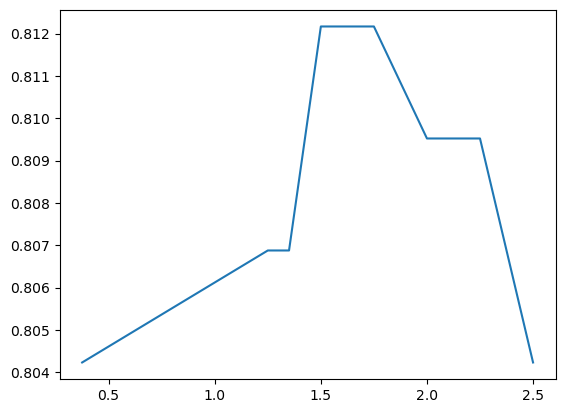

In [47]:
plt.plot(C,score_st);

Sau nhiều lần thử thì nhóm thấy mô hình tốt nhất tại `C=1.5`.

In [23]:
model5 = SVC(C=1.5)
model5.fit(X_train1, y_train1)

predictions = model5.predict(X_test1)

pd.DataFrame({"id": df2.id, "target": predictions}).to_csv("data/submission4__.csv", index=False)

## Kết luận 

Qua quan sát các kết quả của các mô hình cũng như kết quả trên Leaderboard của Kaggle thì mô hình sử dụng SentenceTrasformer cho ra kết quả tốt nhất.

![alt text](leaderboard.png "Title")